<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Position-space" data-toc-modified-id="Position-space-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Position space</a></span><ul class="toc-item"><li><span><a href="#Translation-of-COM-instead-of-rotation-around-origin" data-toc-modified-id="Translation-of-COM-instead-of-rotation-around-origin-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Translation of COM instead of rotation around origin</a></span></li><li><span><a href="#Determine-position-index" data-toc-modified-id="Determine-position-index-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Determine position index</a></span></li></ul></li><li><span><a href="#Orientation-space" data-toc-modified-id="Orientation-space-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Orientation space</a></span><ul class="toc-item"><li><span><a href="#Determine-internal-coordinate-system-(principal-axes)" data-toc-modified-id="Determine-internal-coordinate-system-(principal-axes)-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Determine internal coordinate system (principal axes)</a></span></li><li><span><a href="#Orientation-index-from-reference-principal-axes-and-trajectory" data-toc-modified-id="Orientation-index-from-reference-principal-axes-and-trajectory-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Orientation index from reference principal axes and trajectory</a></span></li></ul></li><li><span><a href="#Full-conversion-3N-coordinates-<->-7D-gridpoint" data-toc-modified-id="Full-conversion-3N-coordinates-<->-7D-gridpoint-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Full conversion 3N coordinates &lt;-&gt; 7D gridpoint</a></span></li></ul></div>

In [16]:
import sys
import os

try:
    os.chdir(r"/home/hanaz63/PAPER_MOLECULAR_ROTATIONS_2022/nobackup/molgri")
    sys.path.append(r"/home/hanaz63/PAPER_MOLECULAR_ROTATIONS_2022/nobackup")
except FileNotFoundError:
    os.chdir(r"D:\HANA\phD\PAPER_2022\molecularRotationalGrids")
    sys.path.append(r"D:\HANA\phD\PAPER_2022\molecularRotationalGrids")
    
import warnings
warnings.filterwarnings("ignore")

In [67]:
import numpy as np
from numpy.typing import NDArray
import MDAnalysis as mda
from scipy.spatial.distance import cdist
from MDAnalysis.analysis.base import AnalysisFromFunction
import seaborn as sns

from molgri.plotting.widgets import ViewManager
from molgri.paths import PATH_OUTPUT_PT, PATH_INPUT_BASEGRO
from molgri.space.fullgrid import FullGrid
from molgri.space.utils import normalise_vectors, k_argmax_in_array, distance_between_quaternions, q_in_upper_sphere

sns.set_context("notebook")

## Position space



### Translation of COM instead of rotation around origin

In [18]:
# generated a file with
# python -m molgri.scripts.generate_pt -m1 H2O -m2 H2O -o "12" -b "8" -t "linspace(0.2, 1, 5)" --recal
pt_name = "H2O_H2O_0403"
pt_universe = mda.Universe(f"{PATH_OUTPUT_PT}{pt_name}.gro",
                           f"{PATH_OUTPUT_PT}{pt_name}.xtc")
len_pt = len(pt_universe.trajectory)

vm = ViewManager(pt_universe)
# plot every 8th frame
# because we have 8 orientations, every 8th structure should be translated version of each other
every_eighth_0 = np.arange(0, len_pt, 8)
print(list(every_eighth_0))
vm.plot_frames_overlapping(every_eighth_0[20:30])

[0, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 128, 136, 144, 152, 160, 168, 176, 184, 192, 200, 208, 216, 224, 232, 240, 248, 256, 264, 272, 280, 288, 296, 304, 312, 320, 328, 336, 344, 352, 360, 368, 376, 384, 392, 400, 408, 416, 424, 432, 440, 448, 456, 464, 472]


NGLWidget()

In [19]:
vm.fresh_view()
every_eighth_3 = np.arange(3, len_pt, 8)
# similar thing for another class of identical orientations
print(list(every_eighth_3))
vm.plot_frames_overlapping(every_eighth_3[20:30])

[3, 11, 19, 27, 35, 43, 51, 59, 67, 75, 83, 91, 99, 107, 115, 123, 131, 139, 147, 155, 163, 171, 179, 187, 195, 203, 211, 219, 227, 235, 243, 251, 259, 267, 275, 283, 291, 299, 307, 315, 323, 331, 339, 347, 355, 363, 371, 379, 387, 395, 403, 411, 419, 427, 435, 443, 451, 459, 467, 475]


NGLWidget()

### Determine position index

In [25]:
# separately determine index in the radial direction and on the sphere, then combine

def assign_2_t_grid(my_trajectory: mda.Universe, t_grid_points: NDArray,
                         second_molecule: str) -> NDArray:
    """
    Given a trajectoryand an array of available radial (t-grid) points, assign each frame of the trajectory
    to the closest radial point.
    
    Args:
        my_trajectory: a Universe of two molecules
        radial_grid_points: a sorted array of available radial grid distances in A like [2, 4, 6]
        second_molecule: a string that tdefines which part of the Universe is a moving molecule
    
    Returns:
        an integer array as long as the trajectory, each element an index of the closest point of the radial grid
        like [0, 0, 0, 1, 1, 1, 2 ...] (for a PT with 3 orientations)
    """
    t_selection = AnalysisFromFunction(lambda ag: np.argmin(np.abs(t_grid_points-np.linalg.norm(ag.center_of_mass())), axis=0),
                                     my_trajectory.trajectory,
                                     my_trajectory.select_atoms(second_molecule))
    t_selection.run()
    t_indices = t_selection.results['timeseries'].flatten()
    return t_indices

def assign_2_o_grid(my_trajectory: mda.Universe, o_grid_points: NDArray, 
                           second_molecule: str) -> NDArray:
    """
    Assign every frame of the trajectory (or PT) to the best fitting point of position grid

    Returns:
        an array of position grid indices
    """
    # now using a normalized com and a metric on a sphere, determine which of o_grid_points is closest
    o_selection = AnalysisFromFunction(lambda ag: np.argmin(cdist(o_grid_points, normalise_vectors(
        ag.center_of_mass())[np.newaxis, :], metric="cos"), axis=0),
                                     my_trajectory.trajectory,
                                     my_trajectory.select_atoms(second_molecule))
    o_selection.run()
    o_indices = o_selection.results['timeseries'].flatten()
    return o_indices

def assign_2_position_grid(my_trajectory: mda.Universe, o_grid_points: NDArray, t_grid_points: NDArray,
                         second_molecule: str):
    """
    Combine assigning to t_grid and o_grid.
    """
    t_assignments = assign_2_t_grid(my_trajectory=my_trajectory, t_grid_points=t_grid_points, 
                                    second_molecule=second_molecule)
    o_assignments = assign_2_o_grid(my_trajectory=my_trajectory, o_grid_points=o_grid_points,
                                   second_molecule=second_molecule)
    # sum up the layer index and o index correctly
    return np.array(t_assignments * len(o_grid_points) + o_assignments, dtype=int)


In [26]:
# test with a PT

my_second_molecule = "bynum 4:6"
my_full_grid = FullGrid(b_grid_name="8", o_grid_name="12", t_grid_name="linspace(0.2, 1, 5)")
position_assignments = assign_2_position_grid(pt_universe, my_full_grid.get_o_grid().get_grid_as_array(), 
                       my_full_grid.get_radii(), my_second_molecule)
print(position_assignments)
# test: a PT should have the first 8 elements in position 0, then 8 in position 1 ...
expected_assignments = np.repeat(np.arange(12*5), 8)
assert np.all(position_assignments == expected_assignments)

[ 0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2
  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  5  5  5  5  5  5  5  5
  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  8  8  8  8  8  8  8  8
  9  9  9  9  9  9  9  9 10 10 10 10 10 10 10 10 11 11 11 11 11 11 11 11
 12 12 12 12 12 12 12 12 13 13 13 13 13 13 13 13 14 14 14 14 14 14 14 14
 15 15 15 15 15 15 15 15 16 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17
 18 18 18 18 18 18 18 18 19 19 19 19 19 19 19 19 20 20 20 20 20 20 20 20
 21 21 21 21 21 21 21 21 22 22 22 22 22 22 22 22 23 23 23 23 23 23 23 23
 24 24 24 24 24 24 24 24 25 25 25 25 25 25 25 25 26 26 26 26 26 26 26 26
 27 27 27 27 27 27 27 27 28 28 28 28 28 28 28 28 29 29 29 29 29 29 29 29
 30 30 30 30 30 30 30 30 31 31 31 31 31 31 31 31 32 32 32 32 32 32 32 32
 33 33 33 33 33 33 33 33 34 34 34 34 34 34 34 34 35 35 35 35 35 35 35 35
 36 36 36 36 36 36 36 36 37 37 37 37 37 37 37 37 38 38 38 38 38 38 38 38
 39 39 39 39 39 39 39 39 40 40 40 40 40 40 40 40 41

In [37]:
# test with a real trajectory: see how long it takes
gro_name = "H2O_H2O_0095"
traj_name = "H2O_H2O_0095_25000"
traj_universe = mda.Universe(f"{PATH_OUTPUT_PT}{gro_name}.gro", f"{PATH_OUTPUT_PT}{traj_name}.xtc")

print(f"Assigning 25000 frames to 25x20={25*20} positions")
traj_full_grid = FullGrid(b_grid_name="20", o_grid_name="25", t_grid_name="linspace(0.2, 1.5, 20)")
position_assignments = assign_2_position_grid(traj_universe, traj_full_grid.get_o_grid().get_grid_as_array(), 
                       traj_full_grid.get_radii(), my_second_molecule)

Assigning 25000 frames to 25x20=500 positions


Most popular assignments are [477  68  28  27  48  31  38  26  33  51] with population [328 336 350 384 350 407 392 457 344 350]


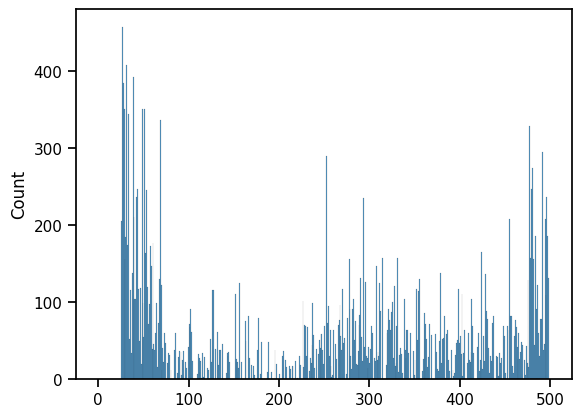

In [45]:
# make a histogram of most populated positions
sns.histplot(position_assignments, stat="count", bins=np.arange(500))

popular, counts = np.unique(position_assignments, return_counts=True)
max_counts = k_argmax_in_array(counts, 10)
print(f"Most popular assignments are {popular[max_counts]} with population {counts[max_counts]}")

In [48]:
# plot some frames of a real trajectory that belong to the same position grid point
vm = ViewManager(traj_universe)
# plot a selection (because too many) that are all assigned to grid point 26
assigned_to_26 = np.where(position_assignments == 26)[0]
# show in VMD for a better view
print(list(assigned_to_26))
vm.plot_frames_overlapping(np.random.choice(assigned_to_26, 30))

[854, 855, 856, 857, 858, 859, 860, 861, 862, 863, 864, 865, 866, 867, 868, 869, 870, 871, 872, 873, 874, 875, 876, 877, 878, 879, 880, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 2265, 2266, 2267, 2268, 2269, 2270, 2271, 2272, 2273, 2274, 2275, 2276, 2277, 2278, 2279, 2280, 2281, 2282, 2283, 2284, 2285, 2286, 2287, 2312, 2313, 2314, 2315, 2316, 2317, 2318, 2319, 2320, 2321, 2632, 2650, 2651, 2652, 2653, 2654, 2655, 2656, 2657, 2658, 2659, 2660, 2661, 2662, 2663, 2664, 2665, 2666, 2667, 4032, 4033, 4034, 4035, 4036, 4037, 4038, 4039, 4040, 4041, 4042, 4043, 4044, 4045, 4046, 4047, 4048, 4049, 4050, 4051, 4602, 4603, 4604, 4605, 4606, 4971, 4972, 4973, 4974, 4975, 4976, 4977, 4978, 4979, 4980, 4981, 4982, 4983, 4984, 4985, 4986, 4987, 4988, 4989, 4990, 4991, 4992, 4993, 4994, 4995, 4996, 4997, 4998, 4999, 5000, 5001, 5002, 5003, 5004, 5005, 5006, 5007, 5008, 5009, 5010, 5011, 5012, 5013, 5014, 5015, 5016, 5017, 5018, 5019, 5020, 5021, 

NGLWidget()

In [49]:
# try another one
vm.fresh_view()
# plot a selection (because too many) that are all assigned to grid point 477
assigned_to_477 = np.where(position_assignments == 477)[0]
# show in VMD for a better view
print(list(assigned_to_477))
vm.plot_frames_overlapping(np.random.choice(assigned_to_477, 30))

[16795, 16796, 16797, 16798, 16799, 16800, 16801, 16802, 16803, 16804, 16805, 16806, 16807, 16808, 16809, 16810, 16811, 16812, 16813, 16814, 16815, 16816, 16817, 16818, 16819, 16820, 16821, 16822, 16823, 16824, 16825, 16826, 16827, 16828, 16829, 16830, 16831, 16832, 16833, 16834, 16835, 16836, 16837, 16838, 16839, 16840, 16841, 16842, 16843, 16844, 16845, 16846, 16847, 16848, 16849, 16850, 16851, 16852, 16853, 16854, 16855, 16856, 16857, 16858, 16859, 16860, 16861, 16862, 16863, 16864, 16865, 16866, 16867, 16868, 16869, 16870, 16871, 16872, 16873, 16874, 16875, 16876, 16877, 16878, 16879, 16880, 16881, 16882, 16883, 16884, 16885, 16886, 16887, 16888, 16889, 16890, 16891, 16892, 16893, 16894, 16895, 16896, 16897, 16898, 16899, 16900, 16901, 16902, 16903, 16904, 16905, 16906, 16907, 16908, 16909, 17106, 17107, 17108, 17109, 17110, 17111, 17112, 17113, 17114, 17115, 17116, 17117, 17118, 17119, 17120, 17121, 17122, 17123, 17124, 17342, 17343, 17344, 17345, 17346, 17347, 17348, 17349, 17350

NGLWidget()

## Orientation space

### Determine internal coordinate system (principal axes)

In [51]:
# determine principal axes

# principal axes of the first frame
pa_zero = pt_universe.select_atoms(second_molecule).principal_axes()
com_zero = pt_universe.select_atoms(second_molecule).center_of_mass()
print(np.round(pa_zero, 3))
print(com_zero+pa_zero[0])

# display principal axes of first frame
vm = ViewManager(pt_universe)
vm.fresh_view()
vm.plot_ith_frame(0)
vm.add_principal_axes(com_zero, pa_zero)
vm.view



[[ 0.     1.     0.   ]
 [-0.599  0.    -0.8  ]
 [-0.8    0.     0.599]]
[-1.70130157  1.          1.05146214]


NGLWidget()

In [52]:
vm.fresh_view()

# principal axes change in relation to the stationary coordinate system when the molecule is re-oriented
# but they remain the same in relation to the molecule itself

# using some selected PT frames for demonstration
for i in [20, 63, 284]:
    pt_universe.trajectory[i]
    pa_current = pt_universe.select_atoms(second_molecule).principal_axes()
    com_current = pt_universe.select_atoms(second_molecule).center_of_mass()
    print(np.round(pa_current, 3))

    # display this
    vm.plot_ith_frame(i)
    vm.add_principal_axes(com_current, pa_current)
vm.view

[[ 0.     0.     1.   ]
 [ 0.8   -0.599  0.   ]
 [ 0.599  0.8    0.   ]]
[[ 0.     0.     1.   ]
 [ 0.8    0.599  0.   ]
 [-0.599  0.8    0.   ]]
[[ 0.     0.     1.   ]
 [ 0.8   -0.599  0.   ]
 [ 0.599  0.8    0.   ]]


NGLWidget()

### Orientation index from reference principal axes and trajectory

In [125]:
def assign_2_b_grid(my_trajectory: mda.Universe, b_grid_points: NDArray, reference_principal_axes: NDArray,
                           second_molecule: str) -> NDArray:
    """
    b grid points are quaternions
    """
    # now using a normalized com and a metric on a sphere, determine which of o_grid_points is closest
    b_selection = AnalysisFromFunction(lambda ag: np.argmin(cdist(b_grid_points, normalise_vectors(
        ag.center_of_mass())[np.newaxis, :], metric=distance_between_quaternions), axis=0),
                                     my_trajectory.trajectory,
                                     my_trajectory.select_atoms(second_molecule))
    b_selection.run()
    b_indices = o_selection.results['timeseries'].flatten()
    return o_indices



from scipy.spatial.transform.rotation import Rotation
from MDAnalysis.analysis import align

my_full_grid = FullGrid(b_grid_name="8", o_grid_name="12", t_grid_name="linspace(0.2, 1, 5)")
b_grid = my_full_grid.b_rotations.get_grid_as_array()


reference_structure = mda.Universe(f"{PATH_INPUT_BASEGRO}H2O.gro")
reference_principal_axes = reference_structure.atoms.principal_axes()

inertia = np.diagonal(reference_structure.atoms.moment_of_inertia())
#reference_principal_axes = np.eye(3)



for i in range(0, 8):
    pt_universe.trajectory[i]
    pa_current = pt_universe.select_atoms(second_molecule).principal_axes()
    
    current_b = Rotation(b_grid[i]).as_matrix()
    print(np.round(pa_current @ np.linalg.inv(reference_principal_axes), 3))
    print("current", np.round(current_b, 3))
    
    md_matrix = align.rotation_matrix(reference_principal_axes, pa_current)
    #print("MD", np.round(md_matrix[0], 3))
    quat = Rotation.from_matrix(md_matrix[0]).as_quat()
    if not q_in_upper_sphere(quat):
        quat = -quat
    #print(np.round(quat, 3))

[[ 0.    -0.8   -0.599]
 [-0.599 -0.48   0.641]
 [-0.8    0.359 -0.48 ]]
current [[ 0.  0. -1.]
 [-1.  0.  0.]
 [ 0.  1.  0.]]
[[ 0.    -0.8   -0.599]
 [-0.599 -0.48   0.641]
 [-0.8    0.359 -0.48 ]]
current [[ 0.  0.  1.]
 [-1.  0.  0.]
 [ 0. -1.  0.]]
[[ 0.    -0.8   -0.599]
 [ 0.599 -0.48   0.641]
 [-0.8   -0.359  0.48 ]]
current [[0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]]
[[ 0.    -0.599  0.8  ]
 [-0.8    0.48   0.359]
 [-0.599 -0.641 -0.48 ]]
current [[ 0.  1.  0.]
 [ 0.  0. -1.]
 [-1.  0.  0.]]
[[ 0.    -0.599  0.8  ]
 [-0.8   -0.48  -0.359]
 [ 0.599 -0.641 -0.48 ]]
current [[ 0. -1.  0.]
 [ 0.  0. -1.]
 [ 1.  0.  0.]]
[[-0.    -0.599  0.8  ]
 [-0.8   -0.48  -0.359]
 [ 0.599 -0.641 -0.48 ]]
current [[0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]]
[[ 0.    -0.8   -0.599]
 [ 0.599 -0.48   0.641]
 [-0.8   -0.359  0.48 ]]
current [[ 0.  0. -1.]
 [ 1.  0.  0.]
 [ 0. -1.  0.]]
[[ 0.    -0.599  0.8  ]
 [-0.8    0.48   0.359]
 [-0.599 -0.641 -0.48 ]]
current [[ 0. -1.  0.]
 [ 0.  0.  1.]
 [-1.  0.  0.]]


In [185]:
# LESSION LEARNED: principal axes are axes and NOT vectors - their direction is NOT clearly defined
# see also: https://math.stackexchange.com/questions/145023/rotation-matrix-from-an-inertia-tensor

# python -m molgri.scripts.generate_pt -m1 H2O -m2 H2O -o "1" -b "20" -t "1" --recal
from molgri.space.rotobj import SphereGrid4DFactory
b_selection = SphereGrid4DFactory().create(alg_name="cube4D", N=20).get_grid_as_array()
b_universe = mda.Universe(f"{PATH_OUTPUT_PT}H2O_H2O_0407.gro", f"{PATH_OUTPUT_PT}H2O_H2O_0407.xtc")

vm = ViewManager(b_universe)
vm.fresh_view()
reference_structure = mda.Universe(f"{PATH_INPUT_BASEGRO}H2O.gro")
reference_principal_axes = reference_structure.atoms.principal_axes()

for i in range(17, 18):
    b_universe.trajectory[i]
    reference_structure = mda.Universe(f"{PATH_INPUT_BASEGRO}H2O.gro")
    reference_principal_axes = reference_structure.atoms.principal_axes()
    my_R = Rotation(b_selection[i]).as_matrix()
    expected_pa = Rotation(b_selection[i]).apply(reference_principal_axes)
    #expected_pa = (my_R @ reference_principal_axes.T).T

    print("my R @ ref", np.round(expected_pa, 3))

    current_principal_axes = b_universe.select_atoms(second_molecule).principal_axes()
    com_current = b_universe.select_atoms(second_molecule).center_of_mass()
    print("end_pa", np.round(current_principal_axes, 3))
    vm.plot_ith_frame(i)
    vm.add_principal_axes(com_current, expected_pa)
    vm.add_principal_axes(com_current, current_principal_axes)
vm.view

[[ 0.5        -0.5        -0.5         0.5       ]
 [ 0.5        -0.5         0.5        -0.5       ]
 [ 0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5        -0.5         0.5       ]
 [ 0.5        -0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5        -0.5       ]
 [ 0.5         0.5        -0.5        -0.5       ]
 [ 0.5        -0.5        -0.5        -0.5       ]
 [ 0.57735027 -0.57735027  0.          0.57735027]
 [ 0.70710678  0.70710678  0.          0.        ]
 [ 0.          0.          0.70710678  0.70710678]
 [ 0.70710678  0.          0.70710678  0.        ]
 [ 0.          0.57735027  0.57735027 -0.57735027]
 [ 0.70710678  0.          0.         -0.70710678]
 [ 0.57735027  0.          0.57735027 -0.57735027]
 [ 0.57735027  0.57735027  0.         -0.57735027]
 [ 0.57735027  0.          0.57735027  0.57735027]
 [ 0.70710678  0.         -0.70710678  0.        ]
 [ 0.57735027  0.57735027 -0.57735027  0.        ]
 [ 0.          0.70710678  0.70

NGLWidget()

In [228]:
# LESSONS LEARNED
# 1. symmetry of water is a problem
# 2. need to save in a higher precision file trr
# 3. need to round structures read from files otherwise values very close to zero can throw off 
#    quaternion projection to correct hemisphere

my_new_u = mda.Universe(f"{PATH_OUTPUT_PT}glucose_glucose_0025.gro", f"{PATH_OUTPUT_PT}glucose_glucose_0025.trr")
b_selection = SphereGrid4DFactory().create(alg_name="cube4D", N=20).get_grid_as_array()



def determine_positive_directions(current_universe, second_molecule):
    pas = current_universe.select_atoms(second_molecule).principal_axes()
    com = current_universe.select_atoms(second_molecule).center_of_mass()
    directions = [0, 0, 0]
    for atom_pos in current_universe.select_atoms(second_molecule).positions:
        for i, pa in enumerate(pas):
            cosalpha = pa.dot(atom_pos-com) #/np.linalg.norm(pa)/np.linalg.norm(atom_pos-com)
            directions[i] = np.sign(cosalpha)
        if not np.any(np.isclose(directions,0)):
            break
    return np.array(directions)

second_molecule_glu = "bynum 13:24"

# reference structure
reference_structure = mda.Universe(f"{PATH_INPUT_BASEGRO}glucose.xyz")
second_molecule_ref = "bynum 1:12"
reference_principal_axes = reference_structure.atoms.principal_axes().T
inverse_pa = np.linalg.inv(reference_principal_axes)
reference_direction = determine_positive_directions(reference_structure, second_molecule_ref)

# frame 0: q3 in direction C-O, frame 1: q3 in direction O
for i in range(20):
    my_new_u.trajectory[i]
    com_current = my_new_u.select_atoms(second_molecule_glu).center_of_mass()
    current_principal_axes = my_new_u.select_atoms(second_molecule_glu).principal_axes().T
    #print(current_principal_axes)
    current_directions = determine_positive_directions(my_new_u, second_molecule_glu)
    direction = current_directions * reference_direction
    # i get a pretty significant numerical error, where?
    # it is already there at the point of calculating principal directions
    produkt = np.multiply(current_principal_axes, np.tile(direction, (3, 1))) @ inverse_pa
    # need to round otherwise assignment to hemisphere can be incorrect
    calc_quat = np.round(Rotation.from_matrix(produkt).as_quat(), 6) 
    if not q_in_upper_sphere(calc_quat):
        calc_quat = -calc_quat
    print(np.allclose(b_selection[i], calc_quat, atol=1e-3, rtol=1e-2), b_selection[i], calc_quat)

True [ 0.5 -0.5 -0.5  0.5] [ 0.5 -0.5 -0.5  0.5]
True [ 0.5 -0.5  0.5 -0.5] [ 0.5 -0.5  0.5 -0.5]
True [0.5 0.5 0.5 0.5] [0.5 0.5 0.5 0.5]
True [ 0.5  0.5 -0.5  0.5] [ 0.5  0.5 -0.5  0.5]
True [ 0.5 -0.5  0.5  0.5] [ 0.5 -0.5  0.5  0.5]
True [ 0.5  0.5  0.5 -0.5] [ 0.5  0.5  0.5 -0.5]
True [ 0.5  0.5 -0.5 -0.5] [ 0.5  0.5 -0.5 -0.5]
True [ 0.5 -0.5 -0.5 -0.5] [ 0.5 -0.5 -0.5 -0.5]
True [ 0.57735027 -0.57735027  0.          0.57735027] [ 0.57735 -0.57735  0.       0.57735]
True [0.70710678 0.70710678 0.         0.        ] [ 0.707107  0.707107  0.       -0.      ]
True [0.         0.         0.70710678 0.70710678] [-0.        0.        0.707107  0.707107]
True [0.70710678 0.         0.70710678 0.        ] [0.707107 0.       0.707107 0.      ]
True [ 0.          0.57735027  0.57735027 -0.57735027] [ 0.       0.57735  0.57735 -0.57735]
True [ 0.70710678  0.          0.         -0.70710678] [ 0.707107 -0.       -0.       -0.707107]
True [ 0.57735027  0.          0.57735027 -0.57735027] [ 0

## Full conversion 3N coordinates <-> 7D gridpoint

In [ ]:
# -> direction: INPUT start coordinates (3N), 7D gridpoint; OUTPUT end coordinates (3N)
# <- direction: INPUT end coordinates (3N), start coordinates (3N); OUTPUT 7D gridpoint